In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import time
import matplotlib.pyplot as plt
from copy import deepcopy as dc
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Import data from Kaggle (kaggle.json downloaded from kaggle and uploaded to google drive folder)

! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d netflix-inc/netflix-prize-data
! unzip netflix-prize-data.zip
data = open('data.csv', mode='w')
row = list()
files = ['/content/combined_data_1.txt',
         '/content/combined_data_2.txt',
         '/content/combined_data_3.txt',
         '/content/combined_data_4.txt']
for file in files:
  print("Reading ratings from {}\n".format(file))
  with open(file) as f:
    for line in f:
      line = line.strip()
      if line.endswith(':'):
        # All below are ratings for this movie, until another movie appears.
        movie_id = line.replace(':', '')
      else:
        row = [x for x in line.split(',')]
        row.insert(0, movie_id)
        data.write(','.join(row))
        data.write('\n')
data.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
 99% 676M/683M [00:12<00:00, 86.1MB/s]
100% 683M/683M [00:12<00:00, 55.2MB/s]
Archive:  netflix-prize-data.zip
  inflating: README                  
  inflating: combined_data_1.txt     
  inflating: combined_data_2.txt     
  inflating: combined_data_3.txt     
  inflating: combined_data_4.txt     
  inflating: movie_titles.csv        
  inflating: probe.txt               
  inflating: qualifying.txt          
Reading ratings from /content/combined_data_1.txt

Reading ratings from /content/combined_data_2.txt

Reading ratings from /content/combined_data_3.txt

Reading ratings from /content/combined_data_4.txt



In [ ]:
# Complete dataframe with all data, remove date column
df_full = pd.read_csv('data.csv', sep=',',
    names=['movie', 'user', 'rating', 'date'])
df_full = df_full.drop(['date'], axis=1)

In [ ]:
def desparsify(df_full, ulim, mlim):      # remove users that have given less than ulim ratings and movies that have received less than mlim ratings
  dfu = df_full.groupby(['user'])['movie'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
  dfm = df_full.groupby(['movie'])['user'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)

  uids = dfu.loc[(dfu["Count"] >= ulim)].user.values.tolist()
  mids = dfm.loc[(dfm["Count"] >= mlim)].movie.values.tolist()

  df = df_full[df_full['user'].isin(uids) & df_full['movie'].isin(mids)]
  df = df.sample(frac=1)

  datapts = df.shape[0]
  nu = df.user.nunique()
  nm = df.movie.nunique()
  sparsity = datapts/(nu*nm)

  return df, datapts, nu, nm, sparsity

In [ ]:
def set_size(df, m, n, indexes_replaced = True):    # df has already replaced user, item idxes to 0-M, 0-N
  if indexes_replaced == False:
    users = random.sample(df.user.unique().tolist(), m)
    movies = random.sample(df.movie.unique().tolist(), n)
    df_res = df[df['user'].isin(users) & df['movie'].isin(movies)]
  else:
    df_res = df[(df['user'] < m) & (df['movie'] < n)]
  df_res = df_res.sample(frac=1,replace=False)
  return df_res

In [ ]:
def replace_idxes(df):    # replace user and movie indices in the df, so that for a dataframe with e.g 1000 unique users, user indices range from 0 to 999
  users = df.user.unique().tolist()
  movies = df.movie.unique().tolist()

  udict = {}
  i = 0
  for j in range(len(users)):
    u = users[j]
    if u not in udict:
      udict[u] = i
      i += 1
    users[j] = udict[u]

  mdict = {}
  i = 0
  for j in range(len(movies)):
    m = movies[j]
    if m not in mdict:
      mdict[m] = i
      i += 1
    movies[j] = mdict[m]

  for index, row in df.iterrows():
    df.at[index,'user']=udict[row['user']]
    df.at[index,'movie']=mdict[row['movie']]

In [ ]:
def split_in_two(R, p):   # p = proportion of input matrix that goes into second output matrix
  r1 = R.copy()
  r2 = np.zeros(R.shape)

  for user in range(R.shape[0]):
    ulist = R[user, :].nonzero()[0]
    l = len(ulist)
    #if l > 10:
    if l >= 0:
      #r2_ratings = np.random.choice(ulist, size=int(round(p*l)), replace=False)
      random.shuffle(ulist)
      r2_ratings = ulist[:round(p*l)]

    else:
      r2_ratings = []
      for u in ulist:
        num = random.uniform(0,1)
        if num < p:
          r2_ratings.append(u)

    r1[user, r2_ratings] = 0
    r2[user, r2_ratings] = R[user, r2_ratings]

  # Assert that matrices are truly disjoint
  assert(np.all((r1 * r2) == 0))
  return r1, r2

In [ ]:
def train_val_test_split(R):
  val_and_test, train = split_in_two(R, 0.8)
  val, test = split_in_two(val_and_test, 0.5)
  return train, val, test

In [ ]:
def demean(R, mu=None):
  mask = np.nonzero(R)
  if mu == None:
    mu = np.mean(R[mask])    # global mean
    R[mask] = R[mask] - mu
    return mu
  else:
    R[mask] = R[mask] - mu    # preprocessing by subtracting global mean

In [ ]:
def als_step(R, solve_mat, fixed_mat, l, lam):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_mat.T.dot(fixed_mat) + np.eye(l) * lam
        b = R.dot(fixed_mat)
        A_inv = np.linalg.inv(A)
        solve_mat = b.dot(A_inv)
        return solve_mat

In [ ]:
def check_users(tr):    # checks if all users (rows) in tr have at least one rating to train on; if not, return list of the user indices that have no ratings
  empties = []
  for user in range(tr.shape[0]):
    if all(u == 0 for u in tr[user, :]):
      ulist = tr[user, :].nonzero()[0]
      empties.append(user)
  return empties

In [ ]:
def compute_mse(y_true, y_pred):  # compute MSE based only on non-zero elements in y_true
        mask = np.nonzero(y_true)
        #mse = mean_squared_error(y_true[mask], y_pred[mask])
        mse = np.square(y_true[mask] - y_pred[mask]).mean()
        return mse

In [ ]:
def compute_diff(y_true, y_pred): # compute difference based only on non-zero elements in y_pred
  mask = np.nonzero(y_true)
  diff = np.zeros(y_true.shape)
  diff[mask] = y_true[mask] - y_pred[mask]
  return diff

In [ ]:
def compute_ranking(U,V,k): # returns a list of sets of top-k recommended items for each user
  Rhat = U.dot(V.T)
  rankings = []
  for user in range(Rhat.shape[0]):
    r = np.argsort(Rhat[user,:])[-k:].tolist()
    #r.reverse()  # not important if we only compare sets
    r = set(r)
    rankings.append(r)
  return rankings

In [ ]:
def ranking_difference(r1, r2):  # set difference between two different top-k recommendations
  r_diff = []
  for u in range(len(r1)):
    d = len(r1[u].difference(r2[u]))
    r_diff.append(d)
  return r_diff

In [ ]:
# Optimization algorithm
def opti(m, n, train, val, test, tol, l, lam, alpha, opt_method = 0, once = False):
  start_time = time.time()
  mu = demean(train)  # subtract the mean of train from train, and return mean
  demean(val, mu); demean(test, mu)  # subtract the mean of train, from val and test

  U = np.random.rand(m,l)-0.5; V = np.random.rand(n,l)-0.5

  MSE_tr = [100]
  MSE_val = []
  MSE_te = []
  Ulist = []
  Vlist = []
  improvement = 0

  Rhat = U.dot(V.T)

  if opt_method == 0:
    for i in range(100):
      MSE_tr.append(compute_mse(train, Rhat))
      MSE_val.append(compute_mse(val, Rhat))
      MSE_te.append(compute_mse(test, Rhat))
      U = als_step(train, U, V, l, lam)
      V = als_step(train.T, V, U, l, lam)
      Rhat = U.dot(V.T)
      Ulist.append(U)
      Vlist.append(V)
      improvement = MSE_tr[-1]/MSE_tr[-2]
      if i > 10:
        if improvement >= tol:
          break
        if all(j < k for j, k in zip(MSE_val[-5:], MSE_val[-4:])):
          break

  if opt_method == 1:
    for i in range(100):
      E = compute_diff(train,Rhat)
      Utemp = U
      U = U*(1-alpha*lam) + alpha*E@V
      V = V*(1-alpha*lam) + alpha*E.T@Utemp
      Rhat = U.dot(V.T)
      MSE_tr.append(compute_mse(train, Rhat))
      MSE_val.append(compute_mse(val, Rhat))
      MSE_te.append(compute_mse(test, Rhat))
      Ulist.append(U)
      Vlist.append(V)
      improvement = MSE_tr[-1]/MSE_tr[-2]
      if i > 10:
        if improvement >= tol:
          break
        if all(j < k for j, k in zip(MSE_val[-5:], MSE_val[-4:])):
          break

  del MSE_tr[0]

  # Identify minimum MSE_val among all iterations, and its index:
  MSE_val_min = min(MSE_val)
  j = MSE_val.index(MSE_val_min)

  # Retrieve U,V from that iteration/index:
  U = Ulist[j]
  V = Vlist[j]

  MSE_te_min = compute_mse(test, U.dot(V.T))
  MSE_tr_min = compute_mse(train, U.dot(V.T))

  #print(time.time()-start_time)
  if once:
    return (MSE_tr, MSE_val, MSE_te, U, V)
  else:
    return (MSE_tr_min, MSE_val_min, MSE_te_min, U, V)

In [ ]:
#start_time = time.time()

# FOR DIFFERENT LEVELS OF SPARSITY
ulim = 100
mlim = 100

df, datapts, nu, nm, sparsity = desparsify(df_full, ulim, mlim)
print(sparsity)

0.022670761226890504


In [ ]:
print(len(df.user.unique()), len(df.movie.unique()))

236117 16795


In [ ]:
# FOR A STARTER: pick out a smaller matrix from the full matrix, in order to create df_max faster later on
df_big = set_size(df, 10000, 15000, indexes_replaced=False)
print(len(df_big.movie.unique()))
#replace_idxes(df_big)

14984


In [ ]:
print(len(df_big.user.unique()))
print(len(df_big.movie.unique()))

10000
14984


In [ ]:
# REPEAT 10 TIMES

m = 1000
startn = 3000; stopn = 14000
jump = 200
it = (stopn - startn)/jump + 1

df_max = set_size(df_big, m, stopn, indexes_replaced = False)
replace_idxes(df_max)
R = csr_matrix((df_max.rating, (df_max.user, df_max.movie)), shape=(m, stopn)).toarray()

In [ ]:
Tr, Val, Te = train_val_test_split(R)
print(check_users(Tr), check_users(Tr[:, :startn]))

[] []
[]
[]
324860
259882
32480
32498
[   3  131  501  628  762  778  842  938  990  996 1240 1252 1363 1521
 1658 2265 3495]


Total no. of parameters = 750000
No. of training data points: 209730 to 257234
Execution time for this run: 364.20 seconds 



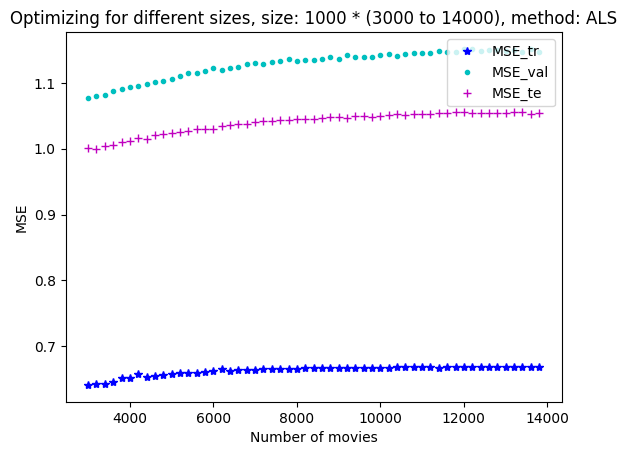

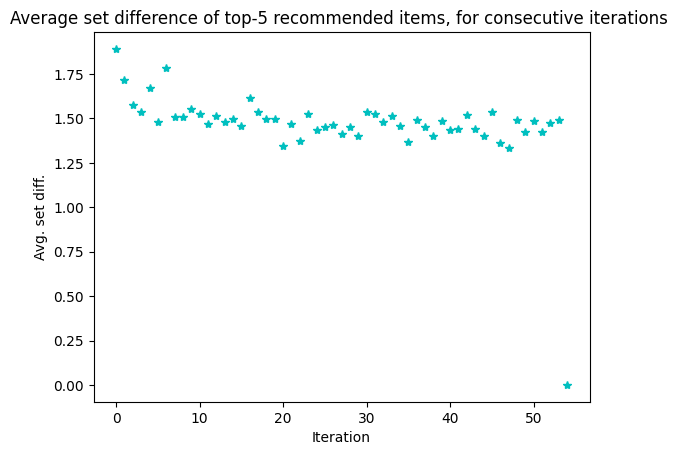

In [ ]:
# OPTIMIZE
start_time = time.time()

once = False
opt_method = 0                      # 0 = ALS, 1 = GD
tol = 0.995; alpha = 0.01           # tolerance: in GD, run until each step doesn't improve more than 1 - tol. alpha = learning parameter/step size in GD
l = 50; lam = 0.05;                 # latent factors and regularization parameter
k = 5                               # top-k recommended items

if opt_method == 0:
  method = 'ALS'
else:
  method = 'GD'

MSE_te = []
MSE_tr = []
MSE_val = []
ranklist = []
all_n = range(startn, stopn, jump)

for n in all_n:
  tr = dc(Tr[:m, :n]); val = dc(Val[:m, :n]); te = dc(Te[:m, :n])
  res = opti(m, n, tr, val, te, tol, l, lam, alpha, opt_method, once)
  if once:
    MSE_tr = res[0]
    MSE_val = res[1]
    MSE_te = res[2]
    break
  else:
    MSE_tr.append(res[0])
    MSE_val.append(res[1])
    MSE_te.append(res[2])
  U = res[3]
  V = res[4]
  ranklist.append(compute_ranking(U,V,k))

print(f'Total no. of parameters = {(m+stopn)*l}')
print(f'No. of training data points: {np.count_nonzero(Tr[:, :startn])} to {np.count_nonzero(Tr)}')
print("Execution time for this run: %.2f seconds \n" % (time.time() - start_time))

if once:
  plt.plot(MSE_tr, 'b*', label='MSE_tr')
  plt.plot(MSE_val, 'c.', label='MSE_val')
  plt.plot(MSE_te, 'm+', label='MSE_te')
  plt.title('One optimization run, size: ' + str(m) + '*' + str(startn) + ', method: ' + method)
  plt.xlabel('Number of optimization steps')
  plt.ylabel('MSE')
  plt.legend(loc='upper right')
  plt.show()

else:
  plt.plot(all_n, MSE_tr, 'b*', label='MSE_tr')
  plt.plot(all_n, MSE_val, 'c.', label='MSE_val')
  plt.plot(all_n, MSE_te, 'm+', label='MSE_te')
  plt.title('Optimizing for different sizes, size: ' + str(m) + ' * (' + str(startn) + ' to ' + str(stopn) + '), method: ' + method)
  plt.xlabel('Number of movies')
  plt.ylabel('MSE')
  plt.legend(loc='upper right')
  plt.show()

  y = []
  for it in range(len(ranklist)):
    el = ranking_difference(ranklist[it], ranklist[-1])
    el = np.mean(el)
    y.append(el)
  plt.plot(y, 'c*')
  plt.title('Average set difference of top-' + str(k) + ' recommended items, compared to the last iteration')
  plt.xlabel('Iteration')
  plt.ylabel('Avg. set diff.')
  plt.show()

Total no. of parameters = 420000
No. of training data points: 70363 to 91080
Execution time for this run: 220.17 seconds 



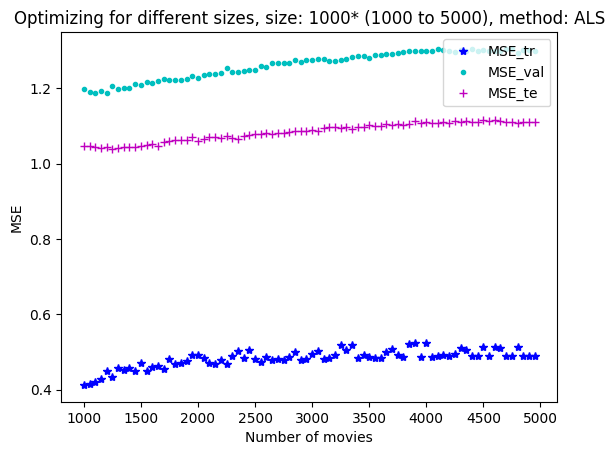

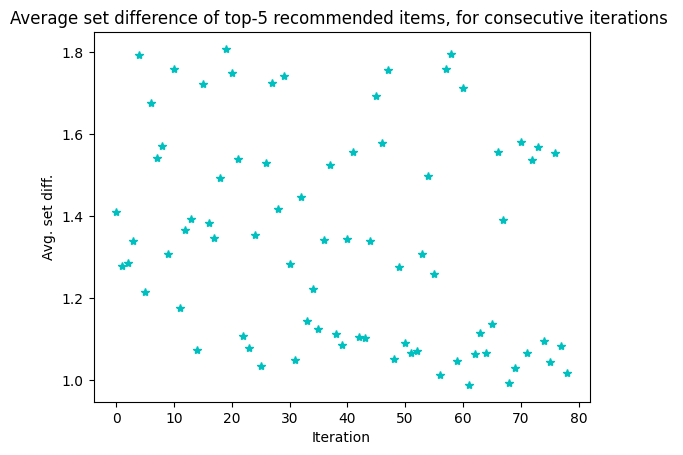

In [ ]:
# OPTIMIZE
start_time = time.time()

once = False
opt_method = 0                      # 0 = ALS, 1 = GD
tol = 0.995; alpha = 0.01           # tolerance: in GD, run until each step doesn't improve more than 1 - tol. alpha = learning parameter/step size in GD
l = 70; lam = 0.05;                 # latent factors and regularization parameter
k = 5                               # top-k recommended items

if opt_method == 0:
  method = 'ALS'
else:
  method = 'GD'

MSE_te = []
MSE_tr = []
MSE_val = []
ranklist = []
all_n = range(startn, stopn, jump)

for n in all_n:
  tr = dc(Tr[:m, :n]); val = dc(Val[:m, :n]); te = dc(Te[:m, :n])
  res = opti(tr, val, te, tol, l, lam, alpha, opt_method, once)
  if once:
    MSE_tr = res[0]
    MSE_val = res[1]
    MSE_te = res[2]
    break
  else:
    MSE_tr.append(res[0])
    MSE_val.append(res[1])
    MSE_te.append(res[2])
  U = res[3]
  V = res[4]
  ranklist.append(compute_ranking(U,V,k))

print(f'Total no. of parameters = {(m+stopn)*l}')
print(f'No. of training data points: {np.count_nonzero(Tr[:, :startn])} to {np.count_nonzero(Tr)}')
print("Execution time for this run: %.2f seconds \n" % (time.time() - start_time))

if once:
  plt.plot(MSE_tr, 'b*', label='MSE_tr')
  plt.plot(MSE_val, 'c.', label='MSE_val')
  plt.plot(MSE_te, 'm+', label='MSE_te')
  plt.title('One optimization run, size: ' + str(m) + '*' + str(startn) + ', method: ' + method)
  plt.xlabel('Number of optimization steps')
  plt.ylabel('MSE')
  plt.legend(loc='upper right')
  plt.show()

else:
  plt.plot(all_n, MSE_tr, 'b*', label='MSE_tr')
  plt.plot(all_n, MSE_val, 'c.', label='MSE_val')
  plt.plot(all_n, MSE_te, 'm+', label='MSE_te')
  plt.title('Optimizing for different sizes, size: ' + str(m) + ' * (' + str(startn) + ' to ' + str(stopn) + '), method: ' + method)
  plt.xlabel('Number of movies')
  plt.ylabel('MSE')
  plt.legend(loc='upper right')
  plt.show()

  y = []
  for it in range(len(ranklist)-1):
    el = ranking_difference(ranklist[it], ranklist[-1])
    el = np.mean(el)
    y.append(el)
  plt.plot(y, 'c*')
  plt.title('Average set difference of top-' + str(k) + ' recommended items, for consecutive iterations ')
  plt.xlabel('Iteration')
  plt.ylabel('Avg. set diff.')
  plt.show()

In [ ]:
# waybackmachine
# jämför alla rankings bara med rankings för sista iterationen